# MiniProyecto 1: 2 abril 2018
#### Cristobal Donoso

In [1]:
import nibabel as nib
import cv2
import numpy as np
import scipy
import matplotlib.pylab as pylab
from matplotlib import pyplot as plt

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
img = nib.load("cases/case_001_2.nii")

In [3]:
header = img.header
#print(header)
print(header.get_data_dtype())
shape = img.shape
img_array = img.get_data()
print(shape)

int16
(288, 320, 33)


### Searching the best slide which is the best model

0


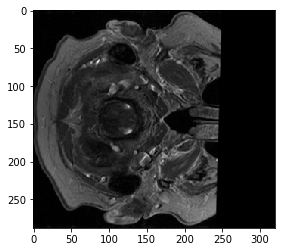

1


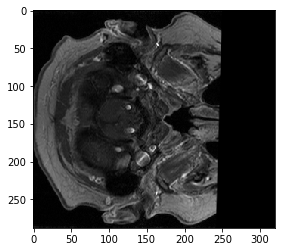

2


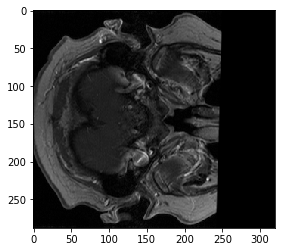

3


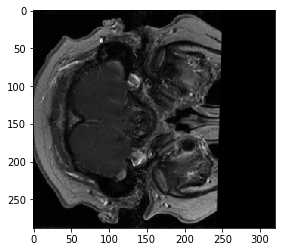

4


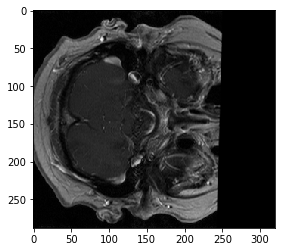

5


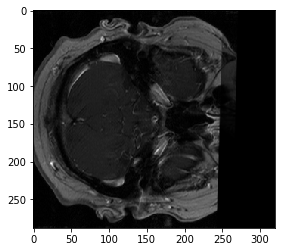

6


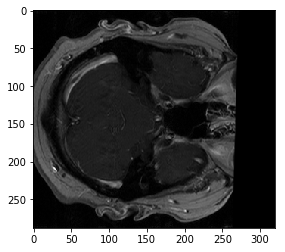

7


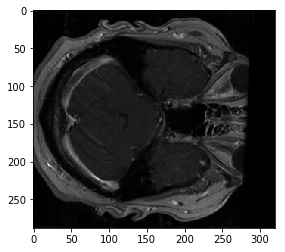

8


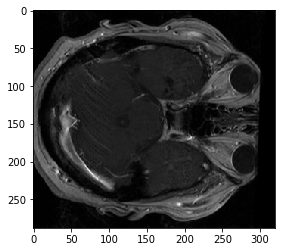

9


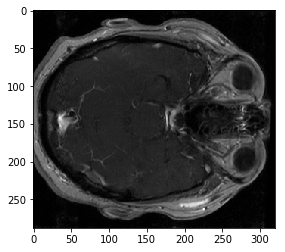

10


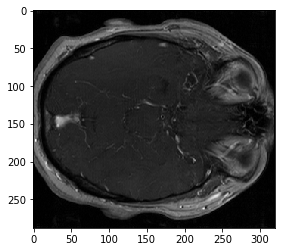

11


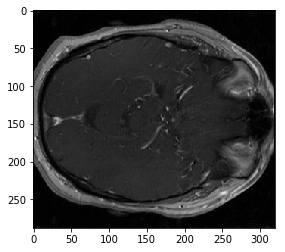

12


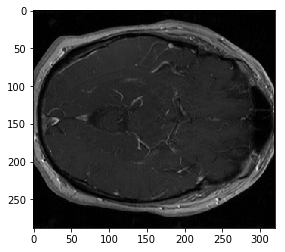

13


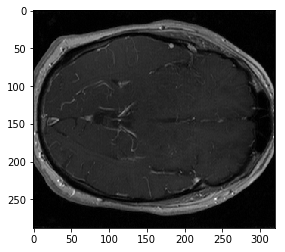

14


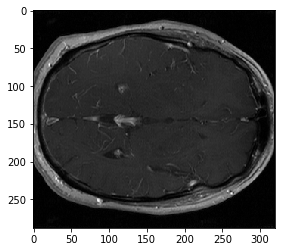

15


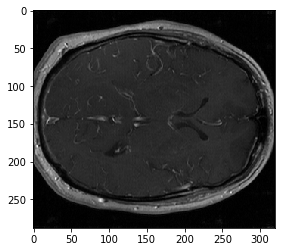

16


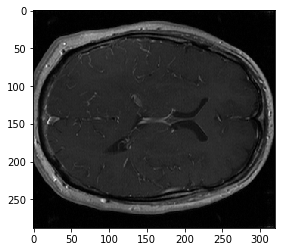

17


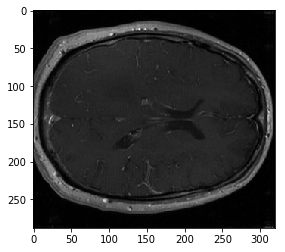

18


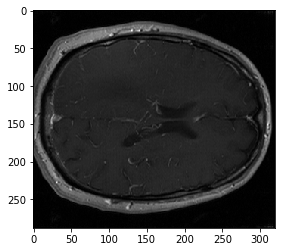

19


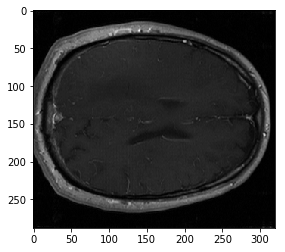

20


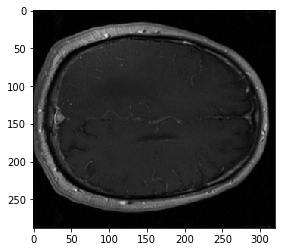

21


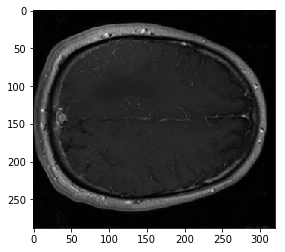

22


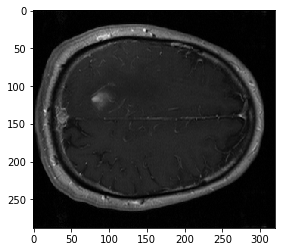

23


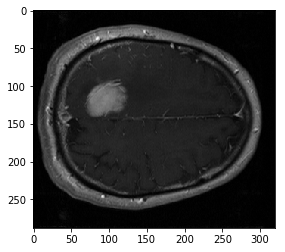

24


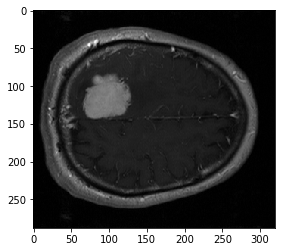

25


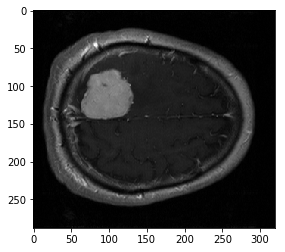

26


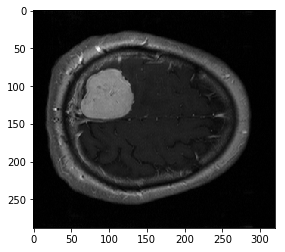

27


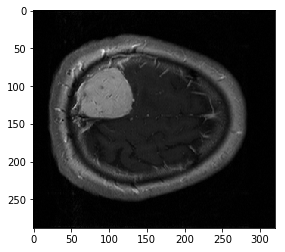

28


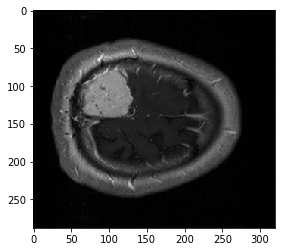

29


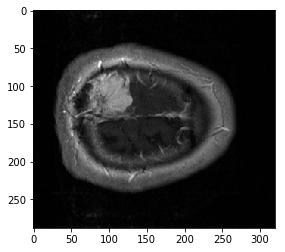

30


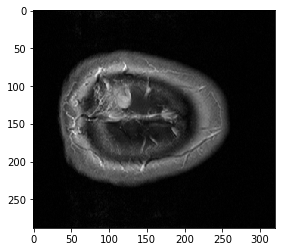

31


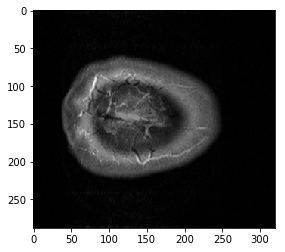

32


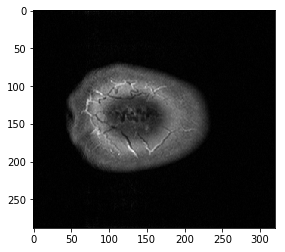

In [4]:
for i in range(0,img_array.shape[2]):
    print(i)
    slide = img_array[:,:,i]
    fig1 = pylab.figure()
    pylab.imshow(slide, cmap=pylab.cm.gist_gray)
    pylab.show()

In [5]:
slide = img_array[:,:,24]
print(slide.shape)
print(slide.dtype)
print(np.unique(slide))

(288, 320)
float64
[0.00000000e+00 1.01649498e+00 1.98678565e+00 ... 2.91498418e+03
 2.95398062e+03 2.97800687e+03]


### K-means application 

(288, 320)


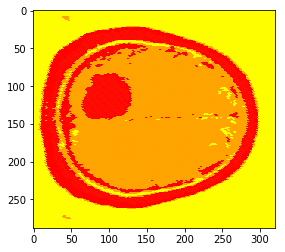

[[ 28  27  28]
 [205 216 205]
 [216 218 213]
 [ 96  94  97]]


In [27]:
img = slide
Z = img.reshape((-1,3))
print(slide.shape)
# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 4
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
image_kmeans = res.reshape((img.shape))

pylab.imshow(image_kmeans, cmap=pylab.cm.autumn_r)
pylab.show()

print(center)


[[0 0 0]
 [1 1 1]
 [0 0 0]
 [0 0 0]]


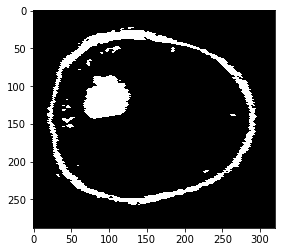

(288, 320)


In [28]:
for i, (centroid) in enumerate(center):
    for j, (value) in enumerate(centroid):
        if i == 1:
            center[i][j] = 1
        else:
            center[i][j] = 0
print(center)
# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
image_kmeans = res.reshape((img.shape))

pylab.imshow(image_kmeans, cmap=pylab.cm.gray)
pylab.show()

#print image size
print(image_kmeans.shape)

### Detecting edges

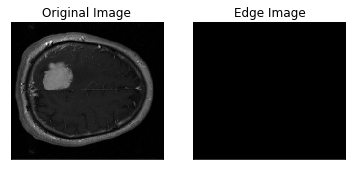

In [29]:
edges = cv2.Canny(image_kmeans,100,200)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()


### Erode and Dilate

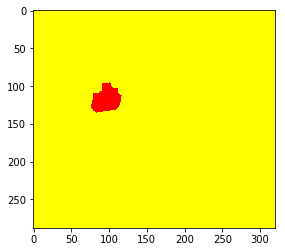

[0 1]
[0 1]


In [30]:
kernel = np.ones((15,15),np.uint8)
erosion = cv2.erode(image_kmeans,kernel,iterations = 1)
pylab.imshow(erosion, cmap=pylab.cm.autumn_r)
pylab.show()
print(np.unique(erosion))
print(np.unique(image_kmeans))


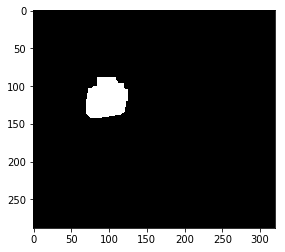

In [31]:
dilation = cv2.dilate(erosion,kernel,iterations = 1)
pylab.imshow(dilation, cmap=pylab.cm.gist_gray)
pylab.show()

In [32]:
np.unique(dilation)
print(dilation.shape)
print(dilation.dtype)
print(np.unique(dilation))

(288, 320)
uint8
[0 1]


### real x mask

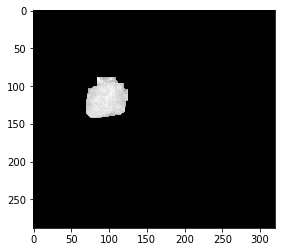

In [33]:
new_slide = img * dilation
pylab.imshow(new_slide, cmap=pylab.cm.gist_gray)
pylab.show()

In [34]:
min_value = np.min(np.unique(new_slide)[1:])
max_value = np.max(np.unique(new_slide)[1:])

print('max tumor :',max_value)
print('min tumor ;',min_value)
print(np.unique(new_slide).shape)
print(np.unique(img).shape)

maxi = np.max(img_array)
lower = np.min(img_array)
print('max all: ',maxi)
print('min all: ',lower)

max tumor : 1598.9928109161556
min tumor ; 805.9881120473146
(482,)
(1806,)
max all:  3027.999938260764
min all:  0.0


In [35]:
size = img_array.shape[2]
new_image = np.zeros((img_array.shape), dtype=np.int16)
print(new_image.shape)
for i in range(22, 29):
    slide = img_array[:,:,i]
    print('reading slide: ',i)
    x_dim = slide.shape[0]
    y_dim = slide.shape[1]
    for x in range(0,x_dim):
        for y in range(0,y_dim):
            partial = float(slide[x,y])
            if (partial>min_value-1) and (partial < max_value+1):
                new_image[x,y,i] = img_array[x,y,i]
            else:
                #print(min_value,'-',partial,'-',max_value)
                new_image[x,y,i] = 0
            
    

(288, 320, 33)
reading slide:  22
reading slide:  23
reading slide:  24
reading slide:  25
reading slide:  26
reading slide:  27
reading slide:  28


0


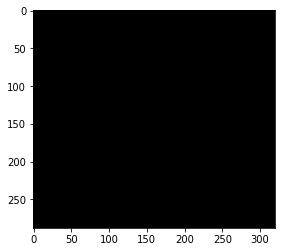

1


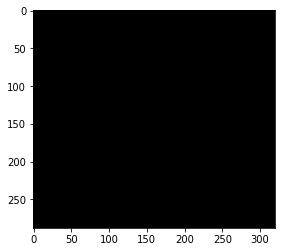

2


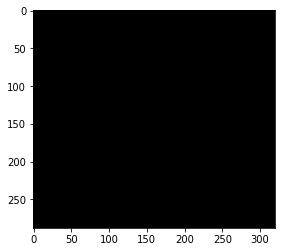

3


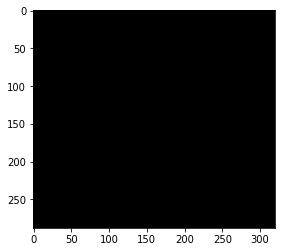

4


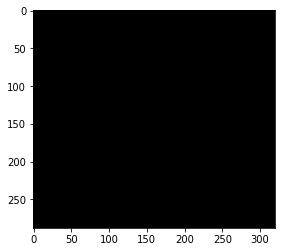

5


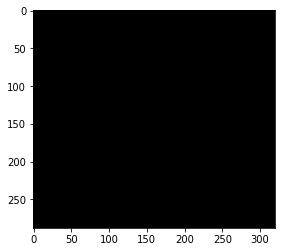

6


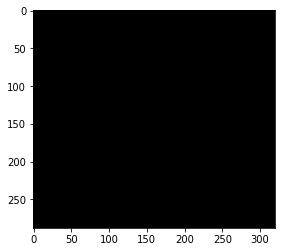

7


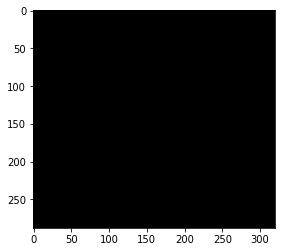

8


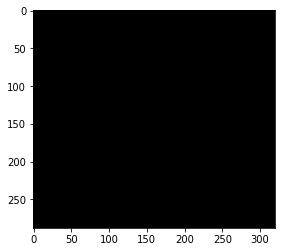

9


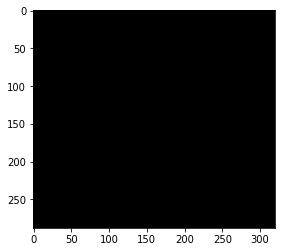

10


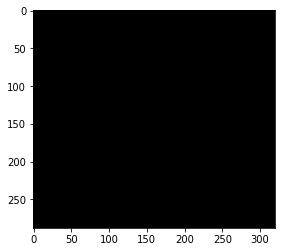

11


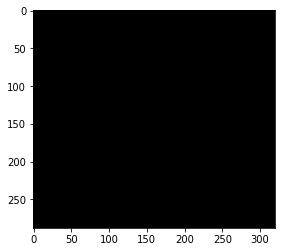

12


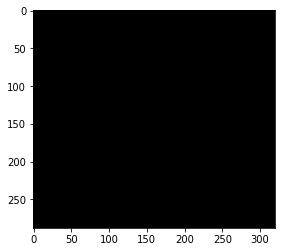

13


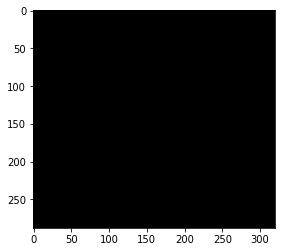

14


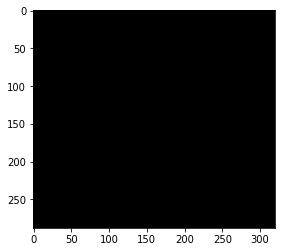

15


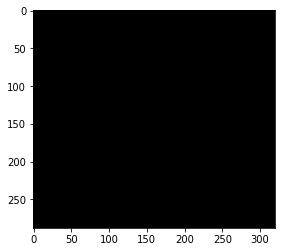

16


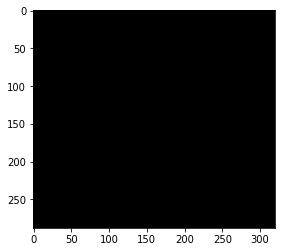

17


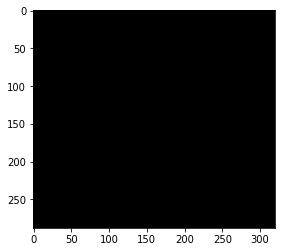

18


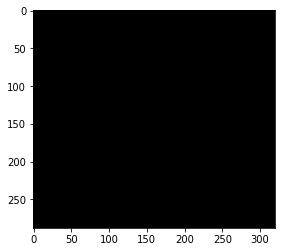

19


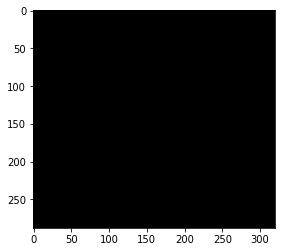

20


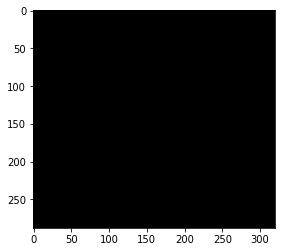

21


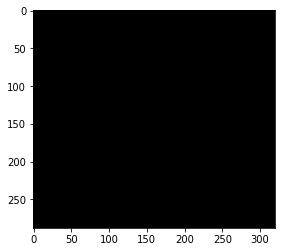

22


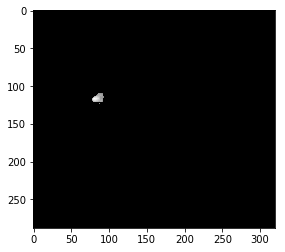

23


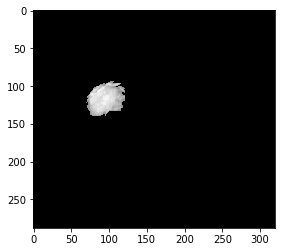

24


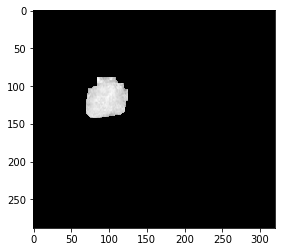

25


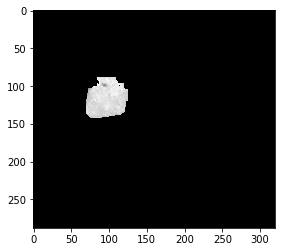

26


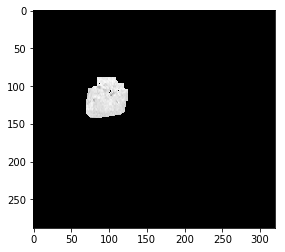

27


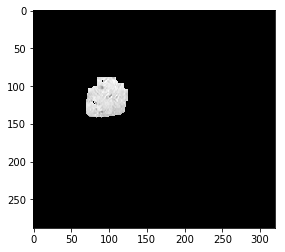

28


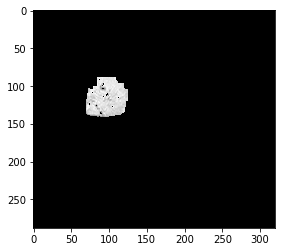

29


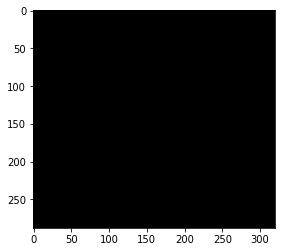

30


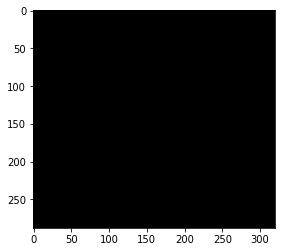

31


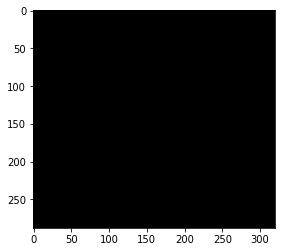

32


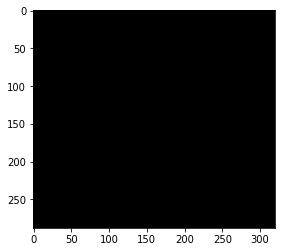

In [36]:
size_new = new_image.shape[2]
for i in range(0, size_new):
    print(i)
    slide_ = new_image[:,:,i] * dilation
    fig1 = pylab.figure()
    pylab.imshow(slide_, cmap=pylab.cm.gist_gray)
    pylab.show()

### Saving image

In [37]:
new_image_nifti = nib.Nifti1Image(new_image, affine=np.eye(4))

In [38]:
nib.save(new_image_nifti, './new_image')

In [39]:
imagen = nib.load('./new_image.nii')
header2 = imagen.header

In [40]:
print( header2 )

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 288 320  33   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          : [1. 0. 0. 0.]
srow_y          : [0. 1. 

In [42]:
print (header.get_zooms())
print (header2.get_zooms())

(0.625, 0.625, 4.3999953)
(1.0, 1.0, 1.0)
